# Quantum rotor model

In [11]:
import netket as nk
nk.config.netket_experimental_fft_autocorrelation = True

from matplotlib import pyplot as plt
import jax.numpy as jnp

from ansatze import *

### Setup VMC simulation

Hyperparameters are tuned for speed not for accuracy. If you want to reproduce the results from the paper, check out the hyperparameters of the different runs in the `data` folder.

In [12]:
N = 4 # number of rotors
hilb = nk.hilbert.Particle(N=N, L=(2*jnp.pi, ), pbc=True) # Hilbert space of quantum rotor model

Define Hamiltonian of quantum rotor model

In [13]:
def rotor_potential_energy(x, N):
    return jnp.sum(jnp.array([jnp.cos(x[i]-x[i+1]) for i in range(N-1)]))
potential = nk.operator.PotentialEnergy(hilb, lambda x : rotor_potential_energy(x, N))
kinetic = nk.operator.KineticEnergy(hilb, mass=1.0)
ha = kinetic - 1.0 * potential

Define how to sample particle configurations. In this case we use the Metropolis-Hastings algorithm. Candidate particle configurations are generated from the previous step by adding Gaussian noise to them.

In [14]:
sab = nk.sampler.MetropolisGaussian(hilb, sigma=0.5, n_chains=16, n_sweeps=16)

Define the ansatz. Check out `ansatze.py` to see their implementation and what is available. You might have to tune the hyperparameters (especially the learning rate) to make another ansatz work. The PQCs are defined in `circuits.py`.

In [15]:
model = PQC2(N=N, layers=2, gate_range=2)
# model = PQC1(N=N, layers=2, gate_range=2)
# model = MeanField(N=N, k_max=4)
# model = Jastrow(N=N, k_max=4, n_max=3)
# model = Hybrid(classical=model1, quantum=model2)

Once we have the ansatz and the sampler, we can define the variational state.

In [16]:
vs = nk.vqs.MCState(sab, model, n_samples=1024, n_discard_per_chain=10, seed=12, sampler_seed=34)

Define the optimizer (set the learning rate) and use stochastic reconfiguration to speed up convergence to the ground state.

In [17]:
op = nk.optimizer.Sgd(0.05)
sr = nk.optimizer.SR(solver=nk.optimizer.solver.svd)

gs = nk.VMC(ha, op, sab, variational_state=vs, preconditioner=sr)

### Run VMC simulation

In [18]:
def cb_acc(step, logged_data, driver):
    logged_data["acceptance"] = float(driver.state.sampler_state.acceptance)
    return True
log=nk.logging.RuntimeLog()

gs.run(n_iter=100, out=log, callback=cb_acc)

100%|██████████| 100/100 [00:28<00:00,  3.47it/s, Energy=-1.1872 ± 0.0047 [σ²=0.0263, R̂=1.0048, τ=0.7<1.4]]


(RuntimeLog():
  keys = ['Energy', 'acceptance'],)

### Plot optimization data

In [19]:
log.data # contains all the logged data

{'Energy': History(
    keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr', 'TauCorrMax'], 
    iters = [0, 1, ... 98, 99] (100 steps),
 ),
 'acceptance': History(
    keys  = ['value'], 
    iters = [0, 1, ... 98, 99] (100 steps),
 )}

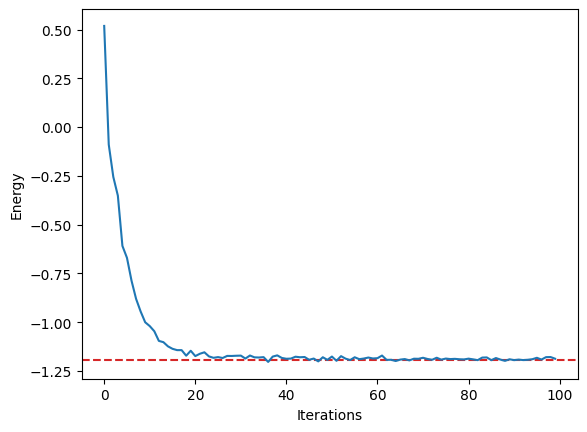

In [20]:
plt.axhline(y = -1.1933614678254223, color = 'tab:red', linestyle = '--') # exact gs energy for N=4 rotors
plt.plot(log.data["Energy"]["iters"], log.data["Energy"]["Mean"])
plt.xlabel('Iterations')
plt.ylabel('Energy');

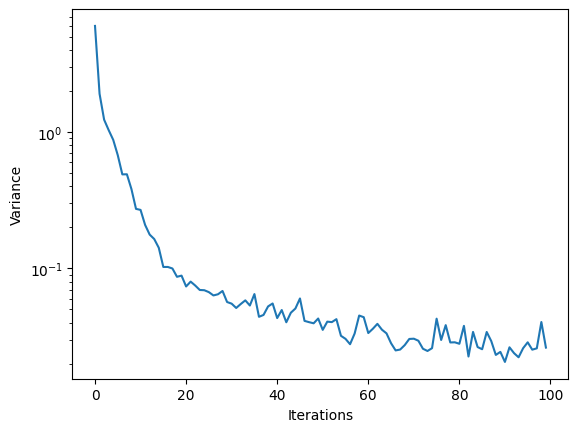

In [21]:
plt.plot(log.data["Energy"]["iters"], log.data["Energy"]["Variance"])
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.yscale('log')

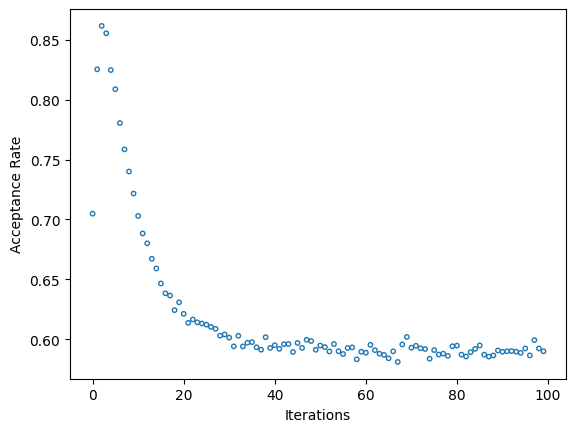

In [22]:
plt.scatter(log.data["Energy"]["iters"], log.data["acceptance"]["value"], s=10, facecolors='none', edgecolors='tab:blue')
plt.xlabel('Iterations')
plt.ylabel('Acceptance Rate');

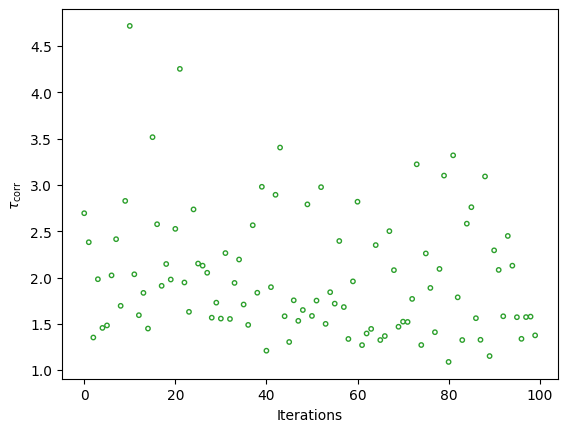

In [23]:
plt.scatter(log.data["Energy"]["iters"], log.data["Energy"]["TauCorrMax"], s=10, facecolors='none', edgecolors='tab:green')
plt.xlabel('Iterations')
plt.ylabel(r'$\tau_{{\mathrm{corr}}}$');